*After completing this exercise please complete the Check For Understanding questions in the LMS*

### Data Source
In this experiment, we will use the CIFAR-10 dataset consists of 60,000 32x32 colour images in 10 classes, with 6000 images per class. There are 50,000 training images and 10,000 test images.

https://www.cs.toronto.edu/~kriz/cifar.html


The images have been downloaded and unzipped for you in the directory cifar-10

They are in a particular python-specific format called pickle. You need not worry about the format's internals, as the site has given the code needed to read such files. The code is given in the first code block below.

**The code returns the contents of each data file as a dictionary**.

## Quick look at the data

There are 8 files in the cifar-10 directory.

batches.meta

data_batch_1

data_batch_2	

data_batch_3

data_batch_4	

data_batch_5

readme.html

test_batch

We will take a peek at these files.

In [ ]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo,encoding='bytes')
    return dict

In [ ]:
list(unpickle("../Datasets/cifar-10/data_batch_1").keys())

[b'filenames', b'data', b'batch_label', b'labels']

**data** a 10,000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.

**labels** a list of 10,000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data.

In [ ]:
unpickle("../Datasets/cifar-10/data_batch_1")[b'filenames'][:10]

[b'leptodactylus_pentadactylus_s_000004.png',
 b'camion_s_000148.png',
 b'tipper_truck_s_001250.png',
 b'american_elk_s_001521.png',
 b'station_wagon_s_000293.png',
 b'coupe_s_001735.png',
 b'cassowary_s_001300.png',
 b'cow_pony_s_001168.png',
 b'sea_boat_s_001584.png',
 b'tabby_s_001355.png']

In [ ]:
unpickle("../Datasets/cifar-10/data_batch_1")[b'labels'][:10]

[6, 9, 9, 4, 1, 1, 2, 7, 8, 3]

In [ ]:
unpickle("../Datasets/cifar-10/data_batch_1")[b'data'].shape

(10000, 3072)

In [ ]:
test_data = unpickle("../Datasets/cifar-10/test_batch")
print(list(test_data.keys())) 
print(len(test_data), len(test_data[b'labels']), test_data[b'data'].shape)

[b'filenames', b'data', b'batch_label', b'labels']
4 10000 (10000, 3072)


In [ ]:
type(test_data[b'data'])

numpy.ndarray

In [ ]:
unpickle("../Datasets/cifar-10/batches.meta")

{b'label_names': [b'airplane',
  b'automobile',
  b'bird',
  b'cat',
  b'deer',
  b'dog',
  b'frog',
  b'horse',
  b'ship',
  b'truck'],
 b'num_cases_per_batch': 10000,
 b'num_vis': 3072}

### Task
Given a query image drawn from the test set, we attempt to find top “relevant” images from the training set
using the K-Nearest Neighbour Method we learned earlier. 

The algorithm is simple, we rank the images present in the training set by their distances from the given query image. ***A
retrieved image is considered “relevant” if the class of retrieved image is same as the query
image.***

### Loading image features

We can use the 3072 pixels as columns of data and find the distance between two 3072 dimension-space points. 

However that is often not the best way from effectiveness or computational efficiency. For example, instead of merely looking at the individual pixels in an image, we may find it more useful to figure out whether both images contain similar colors or similar shapes. The transformation or extraction of such higher order information is what is termed as *Feature Extraction*. This has been done for you for the cifar-10 images.

The images have been converted to relevant 512 features and saved in the file "cifar-10/cifar10features.mat". Let us load them.

In [ ]:
# Load the features of images
import scipy.io as sio
import numpy as np
features = sio.loadmat('../Datasets/cifar-10/cifar10_deep_features.mat')

In [ ]:
train_features = features['x_train']
train_labels = np.transpose(features['y_train'])
test_features = features['x_test']
test_labels = np.transpose(features['y_test'])

In [ ]:
print(train_features.shape, train_labels.shape, test_features.shape, test_labels.shape)

(50000, 512) (50000, 1) (10000, 512) (10000, 1)


### k-NN:

Remember the kNN code:

In [ ]:
import math
import collections

def dist(a, b):
    sqSum = 0
    for i in range(len(a)):
        sqSum += (a[i] - b[i]) ** 2
    return math.sqrt(sqSum)

def kNN(k, train_feats, train_labels, given):
    distances = []
    for i, t in enumerate(train_feats):
        distances.append( (dist(t, given), np.asscalar(train_labels[i])) )
        #if i % 1000 == 0:
            #print(i)
    distances.sort()
    return distances[:k]

def kNN_classify(k, train_feats, train_labels, given):
    tally = collections.Counter()
    top_k = kNN(k, train_feats, train_labels, given)
    for nn in top_k:
        tally.update(nn[-1])
    return tally.most_common(1)[0]

We shall be using the kNN function. Using this function on the full train set, and an image from the test set as "given", we shall obtain the sorted distances of the training samples from the given test sample, along with their labels. This is **retrieval**.

In [ ]:
### Hint: We used the KNN function only. You don't need the KNN_classify function. (Why?)
k = 6000
actual_class = np.asscalar(test_labels[10])
l = kNN(k, train_features, train_labels, test_features[10])

In [ ]:
### Hint: Recall the definition of relevance and use it to calculate precision and recall
### Hint: Number of relevant images is equal to the number of images of that class in the training set 
### Your Code here
def prec_recall(k):
    actual_class = np.asscalar(test_labels[10])
    l = kNN(k, train_features, train_labels, test_features[10])
    result = 0
    for i in range(len(l)):
        if(l[i][1] == actual_class):
            result = result + 1;
    prec = result/len(l)
    recall = result/len(train_labels[train_labels==actual_class])
    return prec, recall

prec,recall = prec_recall(6000)
print("Precision is ",prec,"Recall is ",recall)

Precision is  0.8333333333333334 Recall is  1.0


Ideally, the top samples (the best 10, or best 100...) must have the same label as the given test sample. But this is not always true. To check how good the retrieval performed, we shall look at metrics such as precision@k and recall@k, in addition to accuracy.

Information Retrieval experts usually use two very closely related metrics called Precision@k and Recall@k to evaluate their search engine models where k corresponds to the top-k retrievals. Let’s say q is the query, U is number of images in the training set, R is the set of “relevant” images in the training set and T (k) is the retrieved set
of images from our algorithm.

                $$ p@k = |T(k) ∩ R|/ |T (k)| $$
                
                $$ r@k = |T (k) ∩ R| / |R| $$

**Exercise 2**  :: Compute the precision@k and recall@k for k = 10, 100, 500, 1000, 2000, 3000, 4000, 5000, 5500, 6000. (see this and difference from earlier precision here)


In [ ]:
### Your Code here
K = [10,100,500,1000,2000,3000,4000,5000,6000,7000]
prec = []
recall = []
for i in range(len(K)):
    p,r = prec_recall(K[i])
    print("For k = ",K[i],"Precision is ",p,"Recall is ",r)
    prec.append(p)
    recall.append(r)


For k =  10 Precision is  1.0 Recall is  0.002
For k =  100 Precision is  1.0 Recall is  0.02
For k =  500 Precision is  1.0 Recall is  0.1
For k =  1000 Precision is  1.0 Recall is  0.2
For k =  2000 Precision is  1.0 Recall is  0.4
For k =  3000 Precision is  1.0 Recall is  0.6
For k =  4000 Precision is  1.0 Recall is  0.8
For k =  5000 Precision is  0.9992 Recall is  0.9992
For k =  6000 Precision is  0.8333333333333334 Recall is  1.0
For k =  7000 Precision is  0.7142857142857143 Recall is  1.0


In [ ]:
p,r = prec_recall(5500)
prec[9] = p
recall[9] = r

In [ ]:
### Your Code here
import matplotlib.pyplot as plt
plt.scatter(prec,recall)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.show()

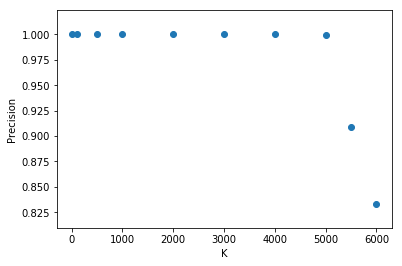

In [ ]:
### Your Code here
K = [10,100,500,1000,2000,3000,4000,5000,6000,5500]
import matplotlib.pyplot as plt
plt.scatter(K,prec)
plt.xlabel("K")
plt.ylabel("Precision")
plt.show()

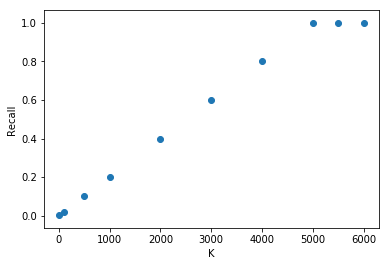

In [ ]:
### Your Code here
K = [10,100,500,1000,2000,3000,4000,5000,6000,5500]
import matplotlib.pyplot as plt
plt.scatter(K,recall)
plt.xlabel("K")
plt.ylabel("Recall")
plt.show()
##Recall is 1 around 5500

#### Yes feature transformation is good in terms of computational efficiency.
